In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler 
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import scikitplot.plotters as skplt
from sklearn.metrics import confusion_matrix, classification_report
import importlib

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import modelling_utils as mu

In [3]:
import submit_data_predict_utils as sdpu

In [4]:
data1 = pd.read_csv('./train_data_all_changes_made_balanced1.csv')

data1 = data1[['device_custom_score', 'os_custom_score', 'app_custom_score', 'channel_custom_score', 'click_time_hour', 'click_time_wday', 'is_attributed']]
data1['click_time_hour'] = data1['click_time_hour'].astype('category')
data1_x = data1.drop(labels='is_attributed', axis=1)
data1_y = data1['is_attributed']

data1_x = mu.data_for_model(data1_x)

train1_x, test1_x, train1_y, test1_y = train_test_split(data1_x, data1_y, train_size=0.8, random_state=16121993, stratify = data1_y.get_values())
dev1_x, test1_x, dev1_y, test1_y = train_test_split(test1_x, test1_y, train_size=0.5, random_state=16121993, stratify = test1_y)
train1_x, train_dev1_x, train1_y, train_dev1_y = train_test_split(train1_x, train1_y, train_size=0.9, random_state=16121993, stratify = train1_y)
 
train1_x, train1_y = RandomUnderSampler(random_state=16121993, ratio='auto').fit_sample(train1_x, train1_y)

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [23]:
tuned_parameters = {'n_estimators': np.array([ 300
#                                                 10, 50, 70, 80, 90, 100
                                             ]),
                    'max_depth': np.array([ 8, 32, 64
#                                             4, 8, 15
                                          ]),
                    'learning_rate': np.array([ 0.1
#                                               0.1, 0.2, 0.5
                                              ]),
                    'gamma': np.array([ 0.01
#                                         0.002, 0.005, 0.01
                                      ]),
                    'max_delta_step': np.array([ 0
#                                                 0, 0.001, 0.002
                                               ]),
                    'colsample_bytree': np.array([ 0.8
#                                                   5/(len(data1.columns) - 1), 
#                                                   8/(len(data1.columns) - 1), 
#                                                   10/(len(data1.columns) - 1)
                                                 ]), 
                    'colsample_bylevel': np.array([ 0.2
#                                                     1, 0.5, 0.2
                                                  ]),
                    'reg_lambda': np.array([ 0.5
#                                             1, 0.5, 0
                                           ])
                   }

k_fold_train1 = StratifiedKFold(n_splits=5, random_state=16121993, shuffle=True).split(train1_x, train1_y)
gb = xgb.XGBClassifier(seed=16121993)

grid = GridSearchCV(gb, 
                    param_grid=tuned_parameters, 
                    cv=k_fold_train1, 
                    n_jobs=-1,
                    scoring='roc_auc',
                    verbose = 2) 

gb_fit = grid.fit(train1_x, train1_y)

gb_fit.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] max_depth=8, gamma=0.01, learning_rate=0.1, n_estimators=300, colsample_bytree=0.8, reg_lambda=0.5, max_delta_step=0, colsample_bylevel=0.2 
[CV] max_depth=8, gamma=0.01, learning_rate=0.1, n_estimators=300, colsample_bytree=0.8, reg_lambda=0.5, max_delta_step=0, colsample_bylevel=0.2 
[CV] max_depth=8, gamma=0.01, learning_rate=0.1, n_estimators=300, colsample_bytree=0.8, reg_lambda=0.5, max_delta_step=0, colsample_bylevel=0.2 
[CV] max_depth=8, gamma=0.01, learning_rate=0.1, n_estimators=300, colsample_bytree=0.8, reg_lambda=0.5, max_delta_step=0, colsample_bylevel=0.2 
[CV]  max_depth=8, gamma=0.01, learning_rate=0.1, n_estimators=300, colsample_bytree=0.8, reg_lambda=0.5, max_delta_step=0, colsample_bylevel=0.2, total= 3.4min
[CV]  max_depth=8, gamma=0.01, learning_rate=0.1, n_estimators=300, colsample_bytree=0.8, reg_lambda=0.5, max_delta_step=0, colsample_bylevel=0.2, total= 3.4min
[CV] max_depth=8, gamma=0.01, lear

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 40.9min finished


{'colsample_bylevel': 0.20000000000000001,
 'colsample_bytree': 0.80000000000000004,
 'gamma': 0.01,
 'learning_rate': 0.10000000000000001,
 'max_delta_step': 0,
 'max_depth': 32,
 'n_estimators': 300,
 'reg_lambda': 0.5}

In [ ]:
gb_final = xgb.XGBClassifier(seed=16121993,
             n_estimators=gb_fit.best_params_['n_estimators'],
             max_depth=gb_fit.best_params_['max_depth'],
             learning_rate=gb_fit.best_params_['learning_rate'],
             gamma=gb_fit.best_params_['gamma'],
             max_delta_step=gb_fit.best_params_['max_delta_step'],
             colsample_bytree=gb_fit.best_params_['colsample_bytree'],
             colsample_bylevel=gb_fit.best_params_['colsample_bylevel'],
             reg_lambda=gb_fit.best_params_['reg_lambda']
            ).fit(train1_x, train1_y)

In [7]:
import pickle

In [8]:
with open('./final_models/xgb_final_2-5-1630.pickle', mode='wb') as f:
    pickle.dump(gb_final, f, protocol=4)

In [15]:
'''
Auxiliar function to show the results of SkLearn Cross-Validation Grid-Search in a fancy way.
'''
def k_folds_evaluation(validation_results):
    print('ROC AUC values: ')
    print(validation_results['test_roc_auc'])
    print('Mean ROC AUC: ')
    print('%0.3f (+/- %0.3f)' % (np.mean(validation_results['test_roc_auc']), np.std(validation_results['test_roc_auc'])))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')    
    print('Accuracies: ')
    print(validation_results['test_accuracy'])
    print('Mean accuracy: ')
    print('%0.3f (+/- %0.3f)' % (np.mean(validation_results['test_accuracy']), np.std(validation_results['test_accuracy'])))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('F1 values: ')
    print(validation_results['test_f1'])
    print('Mean F1: ')
    print('%0.3f (+/- %0.3f)' % (np.mean(validation_results['test_f1']), np.std(validation_results['test_f1'])))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('Precisions: ')
    print(validation_results['test_precision'])
    print('Mean precision: ')
    print('%0.3f (+/- %0.3f)' % (np.mean(validation_results['test_precision']), np.std(validation_results['test_precision'])))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('Recalls: ')
    print(validation_results['test_recall'])
    print('Mean recall: ')
    print('%0.3f (+/- %0.3f)' % (np.mean(validation_results['test_recall']), np.std(validation_results['test_recall'])))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

In [25]:
k_fold_train1 = StratifiedKFold(n_splits=5, random_state=16121993, shuffle=True).split(train1_x, train1_y)

gb_validation_results = cross_validate(
                           gb_final,
                           train1_x,
                           train1_y, 
                           scoring=['roc_auc', 'accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_fold_train1,
                           n_jobs=-1
                        )

In [26]:
k_folds_evaluation(gb_validation_results)

ROC AUC values: 
[ 0.96727755  0.96780942  0.96666175  0.96702928  0.96676834]
Mean ROC AUC: 
0.967 (+/- 0.000)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracies: 
[ 0.91959535  0.9203706   0.91943575  0.91922293  0.91848446]
Mean accuracy: 
0.919 (+/- 0.001)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.91604168  0.91680761  0.91572855  0.91567622  0.91490459]
Mean F1: 
0.916 (+/- 0.001)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.95840045  0.95975129  0.95989866  0.95772754  0.95692946]
Mean precision: 
0.959 (+/- 0.001)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.87726872  0.87754233  0.87544462  0.87716231  0.8764156 ]
Mean recall: 
0.877 (+/- 0.001)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


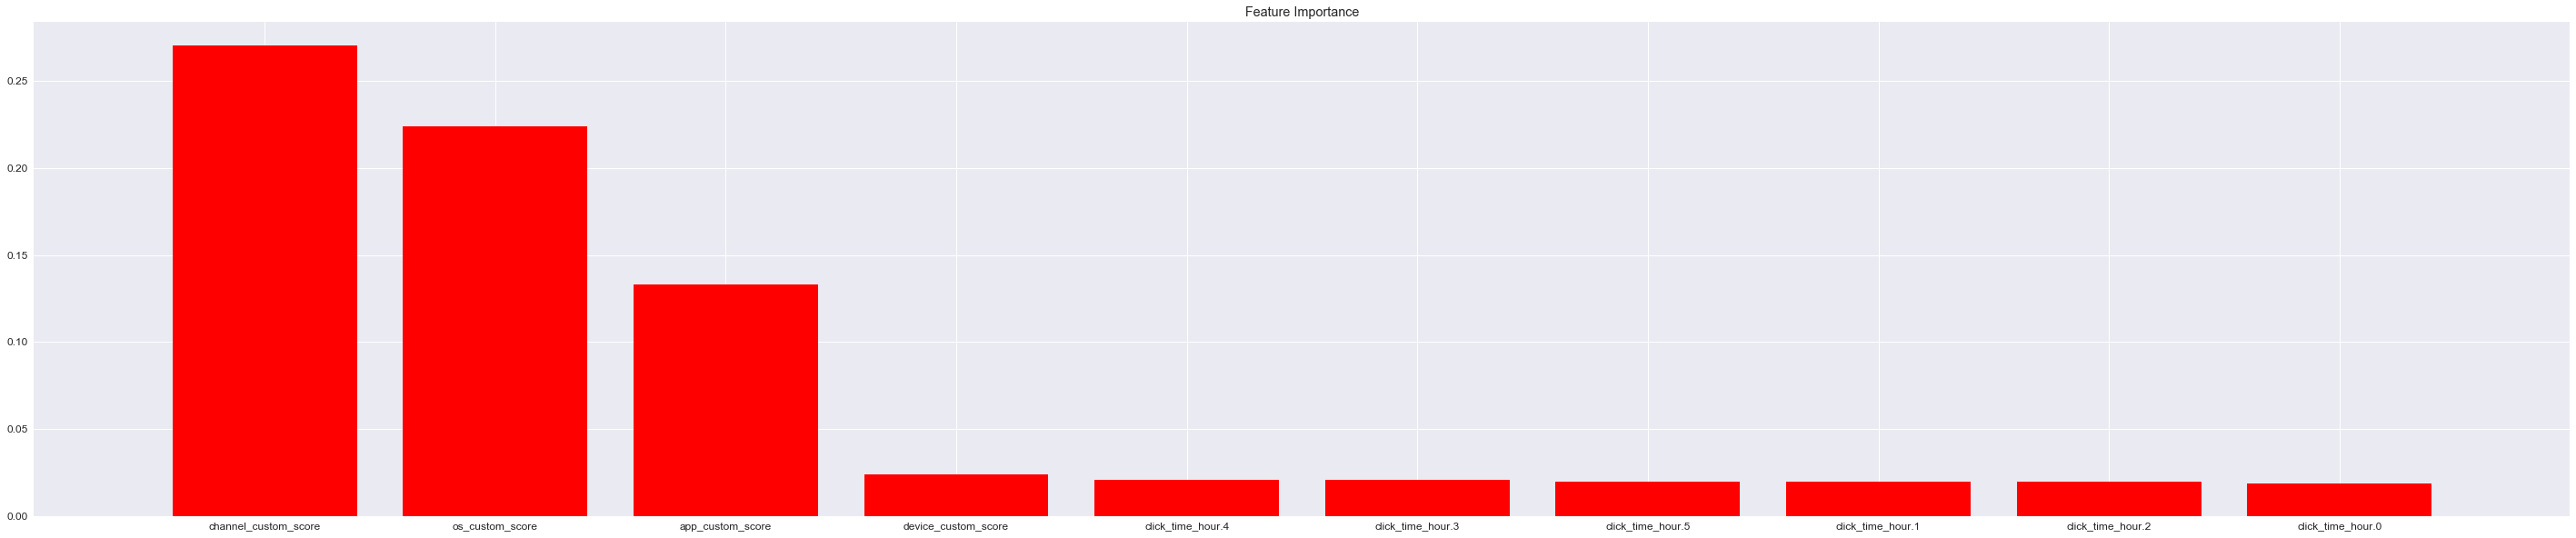

Predicted       0       1     All
Actual                           
0          317446   11483  328929
1           34176  294753  328929
All        351622  306236  657858

             precision    recall  f1-score   support

          0       0.90      0.97      0.93    328929
          1       0.96      0.90      0.93    328929

avg / total       0.93      0.93      0.93    657858



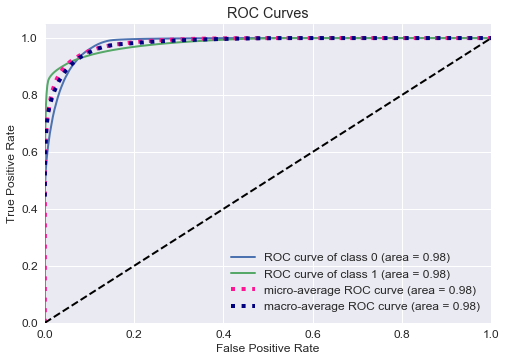

Predicted       0      1     All
Actual                          
0          112060   6036  118096
1            4393  32155   36548
All        116453  38191  154644

             precision    recall  f1-score   support

          0       0.96      0.95      0.96    118096
          1       0.84      0.88      0.86     36548

avg / total       0.93      0.93      0.93    154644



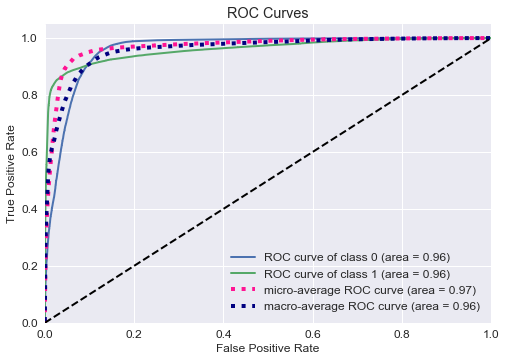

Predicted       0      1     All
Actual                          
0          139971   7650  147621
1            5449  40235   45684
All        145420  47885  193305

             precision    recall  f1-score   support

          0       0.96      0.95      0.96    147621
          1       0.84      0.88      0.86     45684

avg / total       0.93      0.93      0.93    193305



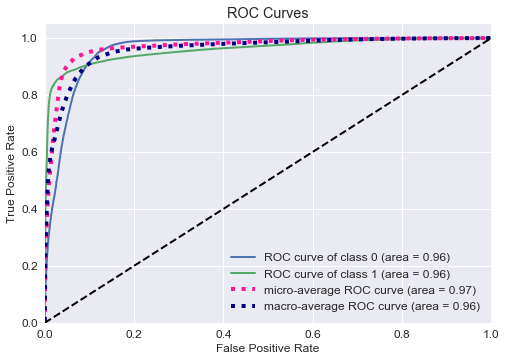

In [9]:
mu.plot_var_importance(gb_final)

mu.report_and_roc_plot(train1_x, train1_y, gb_final)
mu.report_and_roc_plot(train_dev1_x, train_dev1_y, gb_final)
mu.report_and_roc_plot(dev1_x, dev1_y, gb_final)

In [ ]:
submission_pd = pd.read_csv('./test_summit_data_wrangled.csv')
submission_pd.fillna(value = 0, inplace = True)
submission_pd.drop('click_id', inplace = True, axis = 1)
click_ids_aux = pd.read_csv('./test_summit_data_wrangled.csv', usecols = ['click_id'])

predicted_submission = gb_final.predict( sdpu.model_data_preprocessing_for_submit_data(submission_pd) )
pred_aux = pd.DataFrame( predicted_submission[:-24], columns = ['is_attributed'] )
pd.concat([click_ids_aux, pred_aux], axis = 1).to_csv('./submits/submit_xgb_6-5-1233.csv', index = False)

del pred_aux